In [23]:
# import, etc. setups
import numpy as np
from scipy import stats as ss
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy import stats as ss

from BayersianModel import BayersianModel
from Prior import Prior
from copy import deepcopy
import pandas as pd
import os
from MCMC import NaiveSampler

normal2d = np.random.multivariate_normal


# testing the sampling method

this notebook aims to test the correctness of my naive sampler by doing some quantitative analysis on the 2d gaussian. 

#### testing the sampler: correctness and efficiency
- compute effective sample size: i think warne has done this to his experiement 
- could there be a chi-square way, null hypothesis etc way of testing the confidence of this sampler? 
    - this works for independent samples, probabily not good for mcmc
    - this could work for 2d. 
- moment method
- summary statistics: this is the most easy way....
- auto-correlation might also be very helpful

In [24]:
# parameters
m0 = 0
m1 = 1
s0 = 2
s1 = 3
rho = 0.1
true_theta = (m0, m1, s0, s1, rho)
sample_size = 1000


In [25]:
def reshape(theta):
    m0, m1, s0, s1, rho = theta
    mean = np.array([m0, m1])
    cov = np.array([
        [s0**2, s0*s1*rho],
        [s0*s1*rho, s1**2]
    ])
    return mean, cov


In [26]:
mean, cov = reshape(true_theta)


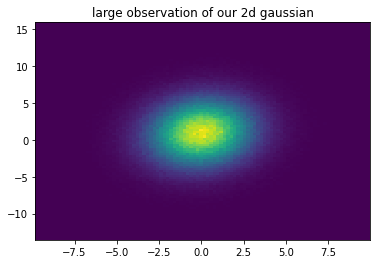

In [27]:
# large_observation to see the distribution of this 2d normal
large_observation = normal2d(mean, cov, 1000000)
plt.hist2d(large_observation[:, 0], large_observation[:, 1], bins=(100, 100))
plt.title('large observation of our 2d gaussian')
print()


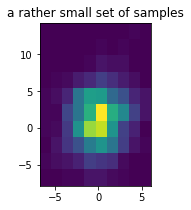

In [28]:
# observation
observation = normal2d(mean, cov, sample_size)
plt.figure(figsize=(2, 3))
plt.hist2d(observation[:, 0], observation[:, 1])
plt.title('a rather small set of samples')
print()


## parameter estimation

there are in total 5 parameters of a 2d gaussian distribution. they are
$$
\mu_0=0,\quad\mu_1=1,\quad std_0=1,\quad std_1 = 1,\quad \rho = 0.5
$$

And they only need to satisfy the constraint that
- $\rho \in [-1,1]$
- $std \ge 0$ (this is optional, but I choose so)

In [29]:
theta_range = np.array(((-10, 10), (-10, 10), (0, 10), (0, 10), (-1, 1))).T
constraints = (None, None, (0, np.inf), (0, np.inf), (-1, 1))


In [30]:
def flatten(theta):
    '''
    theta = (mean, cov)
    return 1d array
    '''
    mean, cov = theta
    m0, m1 = mean
    s0 = np.sqrt(cov[0][0])
    s1 = np.sqrt(cov[1][1])
    rho = cov[0, 1]/(s0*s1)

    return (m0, m1, s0, s1, rho)


def prior_sampler():
    return np.random.uniform(*theta_range)


def log_likelyhood(theta, observation):
    '''
    Inputs
      - theta = (mu,cov)
      - observation = ...

    Output
      - likelyhood of L(theta, observation)
    '''
    try:
        var = multivariate_normal(*reshape(theta))
        return np.sum([var.logpdf(observation)])
    except np.linalg.LinAlgError:
        return - np.inf


## Inference

In [31]:
prior = Prior(
    log_pdf=lambda _: 1,
    sampler=prior_sampler,
    theta_range=theta_range
)
model = BayersianModel(
    prior=prior,
    observation=observation,
    log_likelyhood=log_likelyhood,
)

naive_sampler = NaiveSampler(
    model,
    burn_in=100
)


In [32]:
n_pst = 300000
box_size = .3


In [33]:
pst_samples = naive_sampler.simulation(
    n=n_pst,
    theta_range=constraints,
    box_size=box_size)[200:]


sampling posterior: 100%|██████████| 300100/300100 [00:51<00:00, 5786.89it/s]


In [34]:
M1, M2, S1, S2, R = pst_samples.T


Text(0.5, 1.0, 'MCMC est parameter v.s. True parameter')

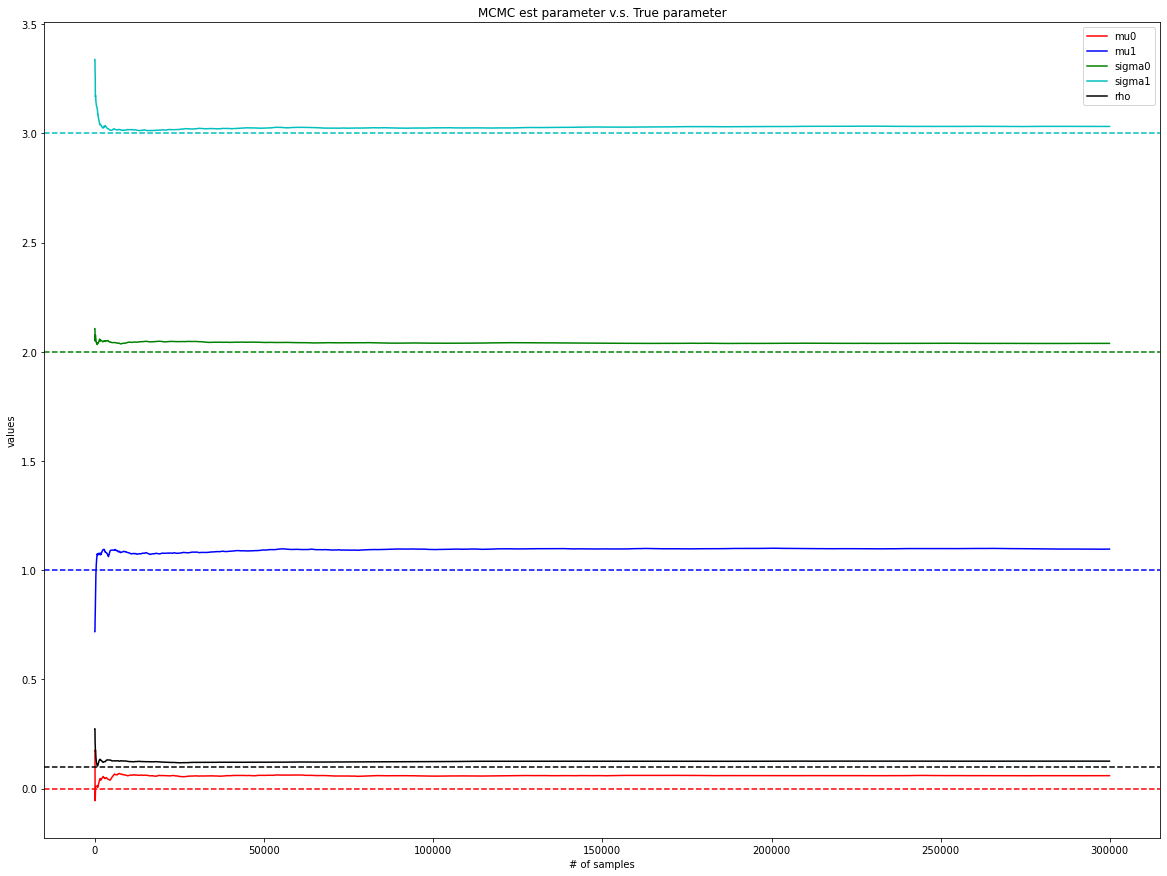

In [35]:
plt.figure(figsize=(20, 15))

plt.plot((M1.cumsum() / np.arange(1, len(M1)+1)), c='r', label='mu0')
plt.axhline(m0, c='r', linestyle='--')
plt.plot((M2.cumsum() / np.arange(1, len(M1)+1)), c='b', label='mu1')
plt.axhline(m1, c='b', linestyle='--')
plt.plot((S1.cumsum() / np.arange(1, len(M1)+1)), c='g', label='sigma0')
plt.axhline(s0, c='g', linestyle='--')
plt.plot((S2.cumsum() / np.arange(1, len(M1)+1)), c='c', label='sigma1')
plt.axhline(s1, c='c', linestyle='--')
plt.plot((R.cumsum() / np.arange(1, len(M1)+1)), c='k', label='rho')
plt.axhline(rho, c='k', linestyle='--')

plt.legend()

plt.xlabel('# of samples')
plt.ylabel('values')
plt.title('MCMC est parameter v.s. True parameter')


## Brutal force MPE

the cell below calculates likelyhood of points around the `mean_theta`, which can be seen as the estimator of the parameters $\theta = (m_0,m_1,s_1,s_2,\rho)$ given by our MCMC sampler. 

In [36]:
def quantile_position(a, arr):
    return 1 - np.searchsorted(arr, a)/(len(arr)-1)


In [37]:
mean_theta = pst_samples.mean(axis=0)
mean_theta_loglikely = model.log_likelyhood(mean_theta, observation)


## MPE medium distance

In [38]:
epsilon = 1
precision = 21  # better be a not small odd nunber.


In [39]:

box, _ = naive_sampler.get_box(mean_theta, epsilon, constraints)
step_size = (box[1] - box[0])/(precision-1)

likelyhoods = model.MPE(
    theta_range=box,
    n=precision, njobs=6)
likelyhoods.sort(key=lambda x: x[1])

mpe_theta, mpe_theta_loglikely = likelyhoods[-1]
log_p_diff = mpe_theta_loglikely - mean_theta_loglikely
print('likelyhood ratio: \t', np.exp(log_p_diff))

steps = (mean_theta - mpe_theta)/step_size
print('total steps:\t\t', precision, '**',
      len(steps), '=', precision**len(steps))
print('steps:\t\t\t', steps)

quantile_arg = quantile_position(
    mean_theta_loglikely, [l for _, l in likelyhoods])
print('At quantile:\t\t', quantile_arg, 'of all the nearby points')


likelyhood ratio: 	 0.6918379033453868
total steps:		 21 ** 5 = 4084101
steps:			 [ 2.77555756e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.27393327e-01]
At quantile:		 -2.4485198690804566e-07 of all the nearby points


The above analysis showed that our naive average estimator of $\theta$ is better than a MPE draw on a medium distance grid

---

## near disntance

In [40]:
epsilon = 0.1
precision = 11  # better be a not small odd nunber.


In [41]:

box, _ = naive_sampler.get_box(mean_theta, epsilon, constraints)
step_size = (box[1] - box[0])/(precision-1)

likelyhoods = model.MPE(
    theta_range=box,
    n=precision, njobs=6)
likelyhoods.sort(key=lambda x: x[1])

mpe_theta, mpe_theta_loglikely = likelyhoods[-1]
log_p_diff = mpe_theta_loglikely - mean_theta_loglikely
print('likelyhood ratio: \t', np.exp(log_p_diff))

steps = (mean_theta - mpe_theta)/step_size
print('total steps:\t\t', precision, '**',
      len(steps), '=', precision**len(steps))
print('steps:\t\t\t', steps)

quantile_arg = quantile_position(
    mean_theta_loglikely, [l for _, l in likelyhoods])
print('At quantile:\t\t', quantile_arg, 'of all the nearby points')


likelyhood ratio: 	 1.0
total steps:		 11 ** 5 = 161051
steps:			 [0. 0. 0. 0. 0.]
At quantile:		 0.0 of all the nearby points


It is also good in its medium distance neighborhood. 

---

Text(0.5, 1.0, 'MCMC est parameter v.s. MPE ')

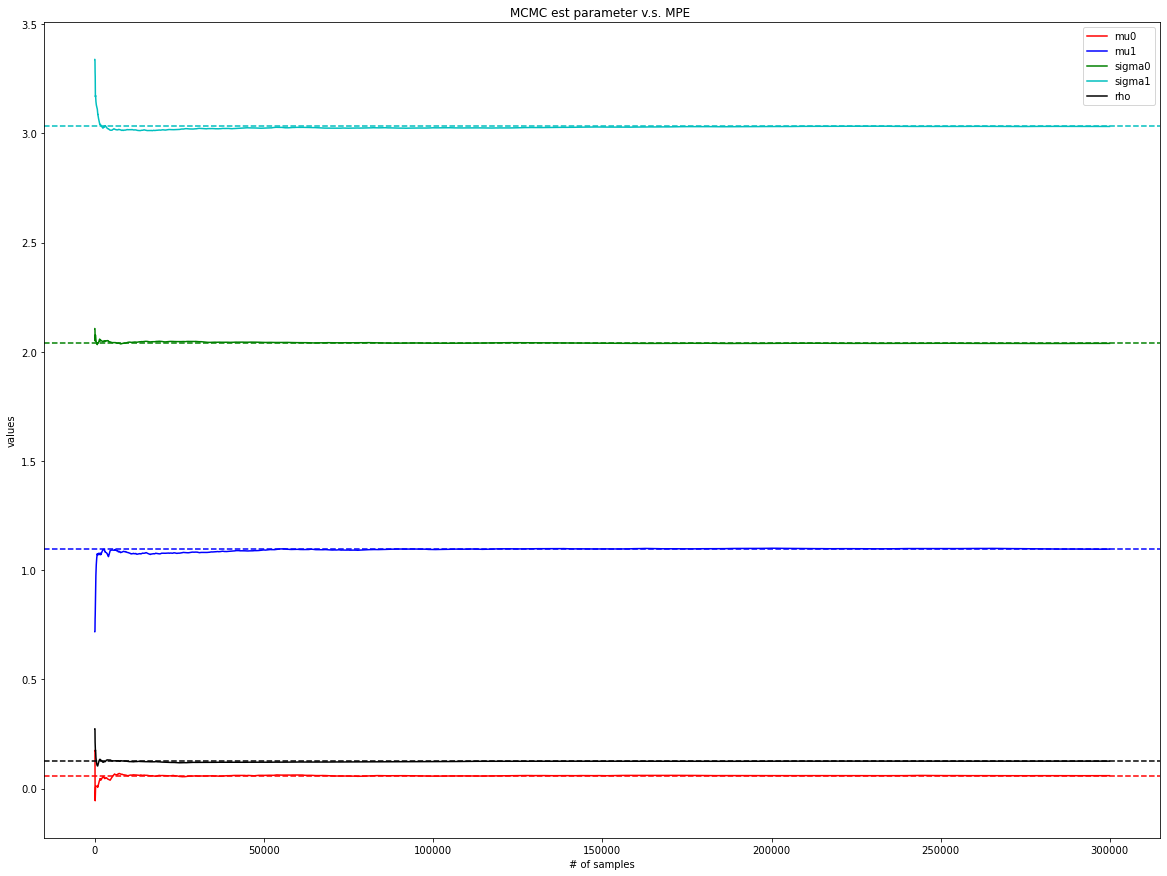

In [42]:
plt.figure(figsize=(20, 15))

plt.plot((M1.cumsum() / np.arange(1, len(M1)+1)), c='r', label='mu0')
plt.axhline(mpe_theta[0], c='r', linestyle='--')
plt.plot((M2.cumsum() / np.arange(1, len(M1)+1)), c='b', label='mu1')
plt.axhline(mpe_theta[1], c='b', linestyle='--')
plt.plot((S1.cumsum() / np.arange(1, len(M1)+1)), c='g', label='sigma0')
plt.axhline(mpe_theta[2], c='g', linestyle='--')
plt.plot((S2.cumsum() / np.arange(1, len(M1)+1)), c='c', label='sigma1')
plt.axhline(mpe_theta[3], c='c', linestyle='--')
plt.plot((R.cumsum() / np.arange(1, len(M1)+1)), c='k', label='rho')
plt.axhline(mpe_theta[4], c='k', linestyle='--')


plt.xlabel('# of samples')
plt.ylabel('values')
plt.legend()
plt.title('MCMC est parameter v.s. MPE ')


Text(0, 0.5, 'values')

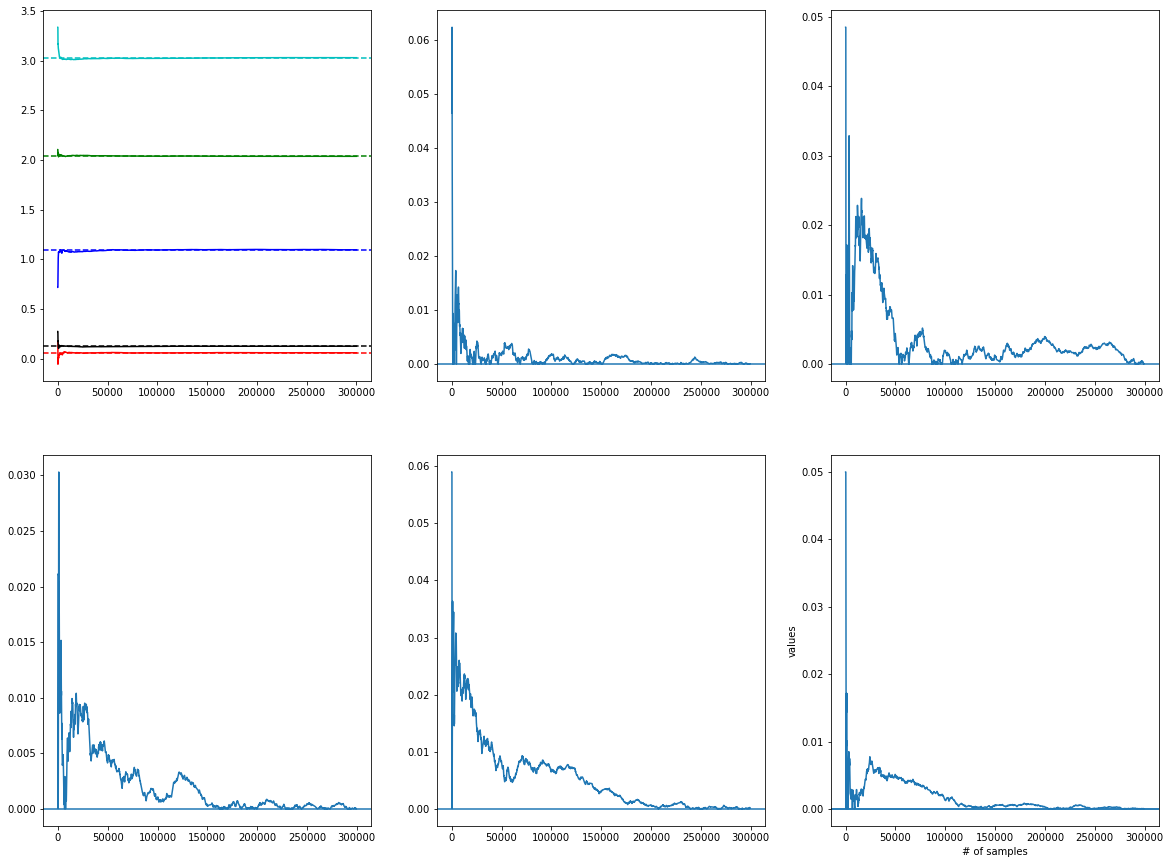

In [43]:
plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)

plt.plot((M1.cumsum() / np.arange(1, len(M1)+1)), c='r', label='mu0')
plt.axhline(mpe_theta[0], c='r', linestyle='--')
plt.plot((M2.cumsum() / np.arange(1, len(M1)+1)), c='b', label='mu1')
plt.axhline(mpe_theta[1], c='b', linestyle='--')
plt.plot((S1.cumsum() / np.arange(1, len(M1)+1)), c='g', label='sigma0')
plt.axhline(mpe_theta[2], c='g', linestyle='--')
plt.plot((S2.cumsum() / np.arange(1, len(M1)+1)), c='c', label='sigma1')
plt.axhline(mpe_theta[3], c='c', linestyle='--')
plt.plot((R.cumsum() / np.arange(1, len(M1)+1)), c='k', label='rho')
plt.axhline(mpe_theta[4], c='k', linestyle='--')

i = 2
for est, true in zip(pst_samples[500:].T, mpe_theta):
    plt.subplot(2, 3, i)

    i += 1

    plt.plot(np.abs((est.cumsum() / np.arange(1, len(est)+1)) - true), label='m1')
    plt.axhline(0)


plt.axhline(0)


plt.xlabel('# of samples')
plt.ylabel('values')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'MPE est parameter v.s. True')

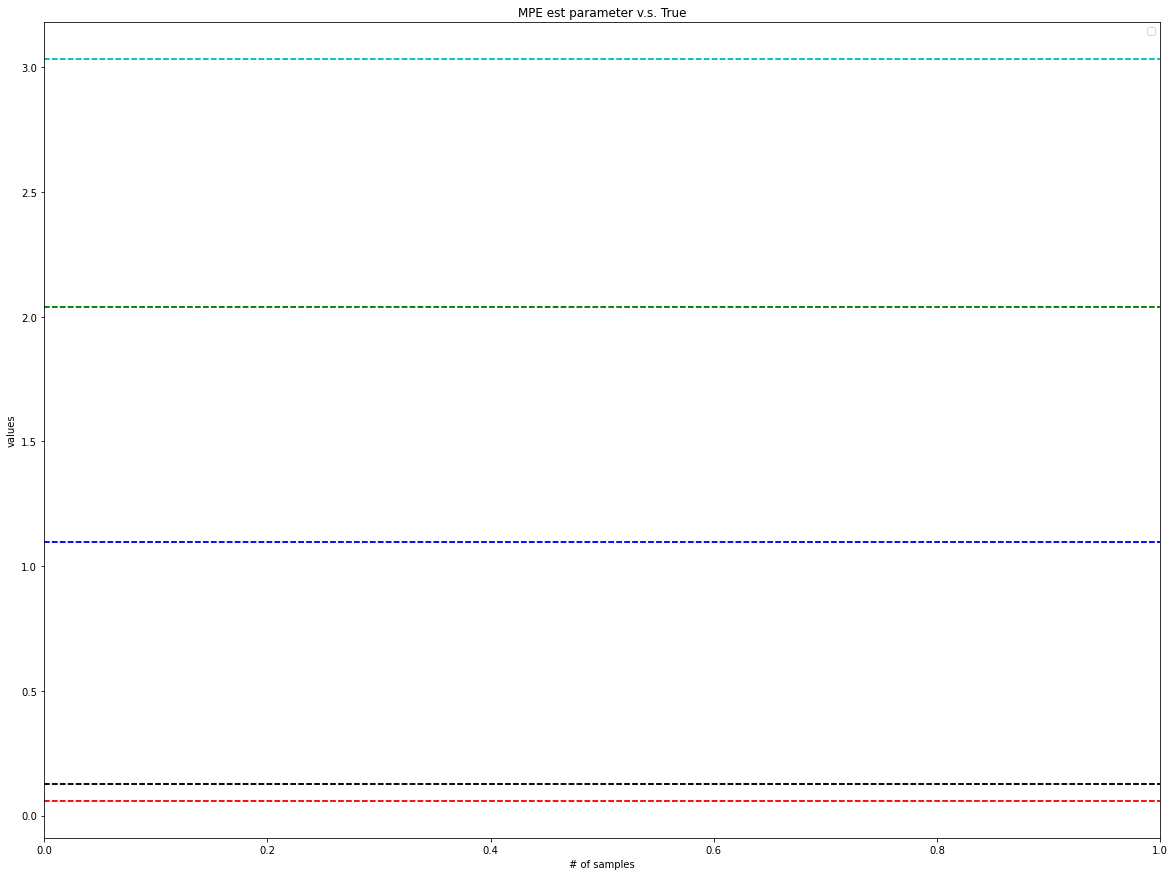

In [44]:
plt.figure(figsize=(20, 15))

plt.axhline(mpe_theta[0], c='r', linestyle='--')
plt.axhline(mean_theta[0], c='r', linestyle='--')
plt.axhline(mpe_theta[1], c='b', linestyle='--')
plt.axhline(mean_theta[1], c='b', linestyle='--')
plt.axhline(mpe_theta[2], c='g', linestyle='--')
plt.axhline(mean_theta[2], c='g', linestyle='--')
plt.axhline(mpe_theta[3], c='c', linestyle='--')
plt.axhline(mean_theta[3], c='c', linestyle='--')
plt.axhline(mpe_theta[4], c='k', linestyle='--')
plt.axhline(mean_theta[4], c='k', linestyle='--')


plt.xlabel('# of samples')
plt.ylabel('values')
plt.legend()
plt.title('MPE est parameter v.s. True')
